In [5]:
import numpy as np
import numba
from numba import cuda
import math
from functools import partial
import warnings
warnings.filterwarnings('ignore', category=numba.NumbaPerformanceWarning)

In [ ]:
%pip install -qqq git+https://github.com/chalk-diagrams/planar git+https://github.com/danoneata/chalk@srush-patch-1
!wget -q https://github.com/srush/GPU-Puzzles/raw/main/robot.png https://github.com/MPKonst/GPU-Puzzles/raw/flash_attn_puzzle/flash_attn_forward_algo.png https://github.com/MPKonst/GPU-Puzzles/raw/flash_attn_puzzle/lib.py

In [6]:
from lib import CudaProblem, Coord

# Bonus: Forward pass of FlashAttention2


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MPKonst/GPU-Puzzles/blob/flash_attn_puzzle/Flash_attention_puzzle.ipynb)

In the following you'll implement a simplified version of the forward pass of FlashAttention 2, as described in
Algorithm 1 in [FlashAttention-2: Faster Attention with Better Parallelism and Work Partitioning
](https://arxiv.org/abs/2307.08691).

 ![image.png](flash_attn_forward_algo.png)

For this naive implementation, we can ignore several details, such as:
- not using optimised matmul operations that can leverage tensor cores
- not applying any within-warp optimisations
- skip storing of the "logsumexp" for rows (which is needed for the backward pass).


In [7]:

def flash_attn_forward_kernel_factory(cuda, tpb_x, hidden_dim):
    """
    Assumptions:    
    1) The kernel will be launched on a block_size (tpb_x, hidden_dim) on a grid size (?, 1)
    2) tpb_x < hidden_dim, so we have enough threads to compute the (tpb_x, tpb_x) matrix of attention logits
    """
    def flash_attn_forward_kernel(out, q, k, v):
        # this will be launched as a tpb_x x hidden_dim block with hidden_dim > tpb_x
        local_i = cuda.threadIdx.x
        local_j = cuda.threadIdx.y
        i = cuda.blockIdx.x * cuda.blockDim.x + local_i
        j = cuda.blockIdx.y * cuda.blockDim.y + local_j
        seqlen = q.shape[0]

        # we assume that hidden_dim is small enough that this can be loaded
        # into shared memory (we can reduce tpb_x, if not)
        q_shared = cuda.shared.array((tpb_x, hidden_dim), numba.float32)
        qkT_and_exp_qkT = cuda.shared.array((tpb_x, tpb_x), numba.float32)
        k_shared = cuda.shared.array((tpb_x, hidden_dim), numba.float32)
        v_shared = cuda.shared.array((tpb_x, hidden_dim), numba.float32)

        out_acc = 0.0
        rowsumexp = 0.0
        rowmax = 0.0

        if i < seqlen and j < hidden_dim:
            q_shared[local_i, local_j] = q[i, j]

        num_tiles = (seqlen + tpb_x - 1) // tpb_x
        for tile in range(num_tiles):
            n_keys = tpb_x if tile != num_tiles - 1 else seqlen - (num_tiles - 1) * tpb_x
            # FILL ME IN
            # 1. read-in the tiles of keys and values (roughly 5 lines)
            ...

            # 2. compute this tile of q@k.T (roughly 6 lines)
            ...

            new_rowmax = qkT_and_exp_qkT[local_i, 0]
            # 3. compute the new rowmax without updating the old one (roughly 7 lines)
            ...

            # 4. exponentiate the attention weights with math.exp (roughly 2 lines)
            ...

            new_rowsumexp = 0.0
            # 5. compute the rowsumexp in the n_queries x n_keys block and 
            #    update the running rowsumexp (roughly 8 lines)
            ...

            new_out = 0.0
            # 6. compute the output contribution and update the out_acc (roughly 5 lines)
            ...
            
            # 7. Update the running rowmax (roughly 2 lines)
            ...
        # 8. Write the output to global memory (roughly 2 lines)
        ...
    return flash_attn_forward_kernel


# Flash Attention Forward
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             0 |             0 |             0 |             0 | 



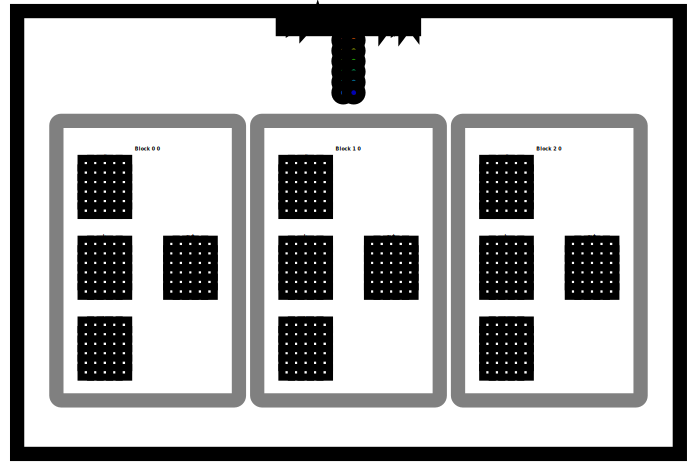

In [9]:
def softmax(x, axis=-1):
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)

def attn_spec(q, k, v):
    return softmax(q@k.T)@v

SEQ_LEN = 5
TPB_x = 2
HIDDEN_DIM = 6
q = np.random.randn(SEQ_LEN, HIDDEN_DIM).astype(np.float32) * np.random.rand()
k = np.random.randn(SEQ_LEN, HIDDEN_DIM).astype(np.float32) * np.random.rand()
v = np.random.randn(SEQ_LEN, HIDDEN_DIM).astype(np.float32) * np.random.rand()

out = np.zeros((SEQ_LEN, HIDDEN_DIM))

problem = CudaProblem(
    "Flash Attention Forward",
    partial(flash_attn_forward_kernel_factory, tpb_x=TPB_x, hidden_dim=HIDDEN_DIM),
    [q, k, v],
    out,
    blockspergrid=Coord((SEQ_LEN + TPB_x - 1) // TPB_x, 1),
    threadsperblock=Coord(TPB_x, HIDDEN_DIM),
    spec=attn_spec,
    input_names=["q", "k", "v"],
)
problem.show(sparse=False, svg_height_factor=10)

In [ ]:
problem.check(atol=1e-7)